In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from typing import List
import tensorflow as tf
from tensorflow.keras import layers, models


In [4]:
import math
from typing import Literal

def shortest_angle_diff(target_angle, current_angle):
    diff = target_angle - current_angle
    diff = (diff + math.pi) % (2 * math.pi) - math.pi
    return diff



In [ ]:
class Position():
    """
    Classe Position:
        distance: Calcul la distance entre la position courante et la position prise en entrée
        add: modifie la position courante de dx et dy
        get_angle: donne l'angle entre deux objet Position
        copy: renvoie une copie de la position
    """
    def __init__(self, x: float, y: float):
        self.x = x
        self.y = y

    def distance(self, other: "Position") -> float:
        return math.sqrt((self.x - other.x)**2 + (self.y - other.y)**2)

    def add(self, dx: float, dy: float):
        self.x += dx
        self.y += dy

    def get_angle(self, other: "Position") -> float:
        delta_x = other.x - self.x
        delta_y = other.y - self.y
        return math.atan2(delta_y, delta_x)

    def copy(self) -> "Position":
        return Position(self.x, self.y)


class Direction():
    """
        Classe Direction:
            rotate: modifie l'angle de la direction courante de delta
            to_vector: transforme l'angle en un vecteur de Position(x, y)
            copy: renvoie un angle
    """
    def __init__(self, angle: float):
        self.angle = angle

    def rotate(self, delta: float):
        self.angle += delta

    def to_vector(self, speed: float) -> (float, float):
        dx = math.cos(self.angle) * speed
        dy = math.sin(self.angle) * speed
        return dx, dy

    def copy(self) -> "Direction":
        return Direction(self.angle)

class BoidsParams():
    """
    Paramètres de Boids selon lesquels on va entraîner notre modèle
    cohesion: proximité au centre du banc
    alignment: alignement à la direction du reste du banc
    separation: distance aux différents membres du banc
    vision_range: distance en pixels à laquelle l'individu peut voir
    min_distance: distance minimale à ses voisins
    """
    def __init__(self):
        self.w_cohesion = 0.03
        self.w_alignment = 0.07
        self.w_separation = 0.2
        self.vision_range = 90
        self.min_distance = 12

class Poisson():
    """
    params_set pour plusieurs bancs séparés:
        - speed = 2.5
        - vision_range = 50
        - vision_angle = math.pi * 1.25
        - alignment_range = 40
        - max_turn = 0.3
        - min_distance = 15
        - w_cohesion = 0.02
        - w_alignment = 0.06
        - w_separation = 0.12

    params_set pour banc unique soudé:
        - speed = 2.5
        - vision_range = 90
        - vision_angle = math.pi * 1.25
        - alignment_range = 80
        - max_turn = 0.3
        - min_distance = 12
        - w_cohesion = 0.03
        - w_alignment = 0.07
        - w_separation = 0.12
        
        
    """
    def __init__(self,
                    pos: Position,
                    dir: Direction,
                    speed: float = 2.5,
                    params = BoidsParams(),
                    vision_angle: float = math.pi * 1.25,
                    alignment_range: float = 80,
                    max_turn: float = 0.3,

                ):
        self.pos = pos
        self.dir = dir
        self.speed = speed
        self.params = params
        self.vision_angle = vision_angle
        self.alignment_range = alignment_range
        self.max_turn = max_turn

    def is_in_vision_cone(self, other_fish: "Poisson") -> bool:
        distance = self.pos.distance(other_fish.pos)

        if distance > self.params.vision_range:
            return False

        angle_to_neighbor = self.pos.get_angle(other_fish.pos)

        angle_diff = shortest_angle_diff(angle_to_neighbor, self.dir.angle)

        # Si la différence d'angle est plus petite que la moitié de l'angle de vision,
        # alors le poisson est dans le cône.
        if abs(angle_diff) < self.vision_angle / 2.0:
            return True

        return False

    def cohesion(self, fish_list: List["Poisson"]):
        mean = Position(0, 0)
        fish_count = 0
        # On parcourt les poissons visibles et pas trop proches, puis on calcule la moyenne de leurs positions
        # et on ajuste la rotation du poisson pour s'y diriger
        for fish in fish_list:
            if fish is self:
                continue
            distance = self.pos.distance(fish.pos)
            if distance <= self.params.min_distance:
                continue
            if self.is_in_vision_cone(fish):
                    mean.x += fish.pos.x
                    mean.y += fish.pos.y
                    fish_count += 1
        if fish_count != 0:
            mean.x /= fish_count
            mean.y /= fish_count
            target_angle = self.pos.get_angle(mean)
            raw_turn = shortest_angle_diff(target_angle, self.dir.angle)
            angle_to_turn = max(-self.max_turn, min(self.max_turn, raw_turn))
            self.dir.rotate(self.params.w_cohesion * angle_to_turn)

    def alignment(self, fish_list: List["Poisson"]):
        sum_cos = 0
        sum_sin = 0
        fish_count = 0

        # On parcourt les poissons voisins et on calcule la moyenne de leurs directions
        # et on ajuste la direction du poisson courant pour s'y diriger
        for fish in fish_list:
            if fish is self:
                continue

            distance = self.pos.distance(fish.pos)

            if distance < self.params.min_distance:
                continue

            if distance < self.alignment_range and self.is_in_vision_cone(fish):

                sum_cos += math.cos(fish.dir.angle)
                sum_sin += math.sin(fish.dir.angle)
                fish_count += 1

        if fish_count != 0:
            # Calcul de l'angle moyen à partir de la moyenne des vecteurs
            avg_cos = sum_cos / fish_count
            avg_sin = sum_sin / fish_count
            mean_angle = math.atan2(avg_sin, avg_cos)

            max_turn = 0.3  # en radians
            raw_turn = shortest_angle_diff(mean_angle, self.dir.angle)
            angle_to_turn = max(-max_turn, min(max_turn, raw_turn))
            self.dir.rotate(self.params.w_alignment * angle_to_turn)

    def separation(self, fish_list: List["Poisson"]):
        """
            Vérifie si des poissons sont trop proches du poisson courant 
        """
        separation_vector = (0.0, 0.0)
        fish_count = 0
        for fish in fish_list:
            if fish is self:
                continue
            distance = self.pos.distance(fish.pos)

            if distance > 0 and distance < self.params.min_distance:
                angle_to_neighbor = self.pos.get_angle(fish.pos)

                magnitude = 1.0 - (distance / self.params.min_distance)

                dx_flee = math.cos(angle_to_neighbor + math.pi) * magnitude
                dy_flee = math.sin(angle_to_neighbor + math.pi) * magnitude
                separation_vector = (separation_vector[0] + dx_flee, separation_vector[1] + dy_flee)
                fish_count += 1

        if fish_count != 0:
            flee_angle = math.atan2(separation_vector[1], separation_vector[0])
            max_turn = 0.3
            raw_turn = shortest_angle_diff(flee_angle, self.dir.angle)
            angle_to_turn = max(-max_turn, min(max_turn, raw_turn))
            self.dir.rotate(self.params.w_separation * angle_to_turn)


    def wrap_position(self, width: int, height: int):
        if self.pos.x < 0:
            self.pos.x += width
        elif self.pos.x > width:
            self.pos.x -= width

        if self.pos.y < 0:
            self.pos.y += height
        elif self.pos.y > height:
            self.pos.y -= height

    def apply_random_fluctuation(self, max_turn_deg: float = 0.5):
        """
        Ajoute une petite rotation aléatoire pour maintenir un léger désordre.
        """
        # Convertir le degré en radian
        max_turn_rad = math.radians(max_turn_deg)

        # Générer une rotation aléatoire entre -max_turn_rad et +max_turn_rad
        random_turn = random.uniform(-max_turn_rad, max_turn_rad)
        self.dir.rotate(random_turn)

    def update(self, fish_list: List["Poisson"], width: int, height: int, is_agent: bool = False):
        """
            Applique les règles de Boids aux individus du banc hors notre agent

        Args:
            fish_list (List[&quot;Poisson&quot;]): _description_
            width (int): la largeur de la fenêtre 
            height (int): la hauteur de la fenêtre
            is_agent (bool, optional): est-ce que le poisson courant est l'agent. Faux par défaut.
        """
        if not is_agent:
            self.cohesion(fish_list)
            self.alignment(fish_list)
            self.separation(fish_list)
            self.apply_random_fluctuation()
        else:
            pass

        dx, dy = self.dir.to_vector(self.speed)
        self.pos.add(dx, dy)

        self.wrap_position(width, height)

class fishEnv:
    def __init__(self, width, height, n_fish: int = 30):
        self.width = width
        self.height = height
        self.n_fish = n_fish
        self.agent_idx = 0
        self.params = BoidsParams()
        self.timestep = 0
        self.max_steps = 2000
        self.fish_list: List["Poisson"] = []
        self._init_fishes()

    def _init_fishes(self):
        self.fish_list = []
        for _ in range(self.n_fish):
            x = random.randint(0, self.width)
            y = random.randint(0, self.height)
            dir = Direction(random.uniform(-math.pi, math.pi))
            self.fish_list.append(
                Poisson(
                    Position(x, y),
                    dir,
                    params=self.params
                ))

    def reset(self):
        self._init_fishes()

    def step(self):
        for fish in self.fish_list:
            fish.update(self.fish_list, self.width, self.height)

    def reset_rl(self):
        self._init_fishes()
        self.agent_idx = 0
        self.timestep = 0

        state = self.compute_state()
        return state

    def step_rl(self, action):
        """
        On met à jour l'environnement et on calcule la récompense de l'agent suivant l'action qu'il a décidé d'effectuer
        On reset l'environnement si l'agent est beaucoup trop loin du centre ou si on atteint la fin d'une période
        """
        agent = self.fish_list[self.agent_idx]

        delta = math.radians(15)

        if(action == 1): # tourner à gauche
            agent.dir.rotate(delta)
        if(action == 2): # tourner à droite
            agent.dir.rotate(-delta)

        for i, fish in enumerate(self.fish_list):
            is_agent = (i == self.agent_idx)
            fish.update(self.fish_list, self.width, self.height, is_agent=is_agent)
        self.timestep += 1
        reward, dist_center_norm = self.compute_reward()
        next_state = self.compute_state()

        timeout = (self.timestep >= self.max_steps)
        failure = (dist_center_norm > 0.8)

        done = timeout or failure

        info = {
            "timeout": timeout,
            "failure": failure,
            "dist_center_norm": dist_center_norm,
        }

        return next_state, reward, done, info



    def compute_state(self):
        """
            Calcule l'état courant de l'agent sous forme d'un vecteur compact.

            L'état représente une description synthétique de la structure locale
            du banc autour de l'agent, inspirée des règles du modèle Boids.

            Le vecteur d'état est composé de 7 variables :
            ------------------------------------------------
            1. neighbors_count_norm :
                Densité locale normalisée (nombre de voisins visibles).
            2. cos_center, sin_center :
                Direction vers le centre local (ou global en cas d'isolement),
                encodée en cosinus/sinus.
            3. cos_align, sin_align :
                Alignement de l'agent avec la direction moyenne des voisins
                (ou du banc global si aucun voisin n'est visible).
            4. avg_dist_norm :
                Distance moyenne normalisée aux voisins (ou distance au centre global).
            5. danger :
                Indicateur binaire signalant une proximité dangereuse avec un voisin.        
        """
        agent = self.fish_list[self.agent_idx]
        neighbors = []
        Nmax = 10

        # --- Variables d'état (initialisation) ---
        neighbors_count_norm = 0.0
        cos_center = 0.0
        sin_center = 0.0
        cos_align = 0.0
        sin_align = 0.0
        avg_dist_norm = 1.0
        danger = 0.0

        mean_x = 0.0
        mean_y = 0.0
        avg_cos = 0.0
        avg_sin = 0.0
        mean_dist = 0.0

        for fish in self.fish_list:
            if fish is agent:
                continue
            if agent.is_in_vision_cone(fish):
                neighbors.append(fish)

        if len(neighbors) == 0:
            center_x = 0.0
            center_y = 0.0
            sum_cos = 0.0
            sum_sin = 0.0

            for fish in self.fish_list:
                center_x += fish.pos.x
                center_y += fish.pos.y
                sum_cos += math.cos(fish.dir.angle)
                sum_sin += math.sin(fish.dir.angle)

            n_total = len(self.fish_list)
            center_x /= n_total
            center_y /= n_total
            center = Position(center_x, center_y)

            angle_center = agent.pos.get_angle(center)
            delta_center = shortest_angle_diff(angle_center, agent.dir.angle)
            cos_center = math.cos(delta_center)
            sin_center = math.sin(delta_center)

            sum_cos /= n_total
            sum_sin /= n_total
            mean_dir = math.atan2(sum_sin, sum_cos)
            delta_align = shortest_angle_diff(mean_dir, agent.dir.angle)
            cos_align = math.cos(delta_align)
            sin_align = math.sin(delta_align)

            dist_center = agent.pos.distance(center)
            max_dist = math.hypot(self.width, self.height) / 2.0
            avg_dist_norm = min(1.0, dist_center / max_dist)

            neighbors_count_norm = 0.0
            danger = 0.0

            state = [
                neighbors_count_norm,
                cos_center, sin_center,
                cos_align, sin_align,
                avg_dist_norm,
                danger
            ]
            return np.array(state, dtype=np.float32)

        else:
            n = len(neighbors)
            neighbors_count_norm = min(n, Nmax) / Nmax

            for fish in neighbors:
                mean_x += fish.pos.x
                mean_y += fish.pos.y
                avg_cos += math.cos(fish.dir.angle)
                avg_sin += math.sin(fish.dir.angle)
                neighbor_distance = agent.pos.distance(fish.pos)
                mean_dist += neighbor_distance
                if neighbor_distance < agent.params.min_distance:
                    danger = 1.0

            mean_x /= n
            mean_y /= n
            angle_center = agent.pos.get_angle(Position(mean_x, mean_y))
            delta = shortest_angle_diff(angle_center, agent.dir.angle)
            cos_center = math.cos(delta)
            sin_center = math.sin(delta)

            avg_cos /= n
            avg_sin /= n
            mean_dir = math.atan2(avg_sin, avg_cos)
            delta_align = shortest_angle_diff(mean_dir, agent.dir.angle)
            cos_align = math.cos(delta_align)
            sin_align = math.sin(delta_align)

            mean_dist /= n
            avg_dist_norm = min(1.0, mean_dist / agent.params.vision_range)

            state = [
                neighbors_count_norm,
                cos_center, sin_center,
                cos_align, sin_align,
                avg_dist_norm,
                danger
            ]
            return np.array(state, dtype=np.float32)


    def compute_reward(self):
        """
        Calcul de la récompense de l'agent. Celle-ci baisse si:
        - l'agent est loin du centre du banc
        - l'agent n'est pas aligné avec la direction globale du banc
        - l'agent est isolé et a très peu de voisins
        
        
        """
        agent = self.fish_list[self.agent_idx]

        center_x = 0.0
        center_y = 0.0
        sum_cos = 0.0
        sum_sin = 0.0

        neighbors_count = 0
        Nmax = 10

        # poids des termes (à ajuster si besoin)
        w_dist = 1.0
        w_align = 0.5
        w_iso = 0.3

        # 1) centre global + direction moyenne + densité
        for fish in self.fish_list:
            center_x += fish.pos.x
            center_y += fish.pos.y
            sum_cos += math.cos(fish.dir.angle)
            sum_sin += math.sin(fish.dir.angle)
            if agent.is_in_vision_cone(fish) and fish is not agent:
                neighbors_count += 1

        n = len(self.fish_list)
        center_x /= n
        center_y /= n
        center = Position(center_x, center_y)

        dist_center = agent.pos.distance(center)
        max_dist = math.hypot(self.width, self.height) / 2.0
        dist_center_norm = min(dist_center / max_dist, 1.0)   # 0 proche du centre, 1 très loin

        sum_cos /= n
        sum_sin /= n
        mean_dir = math.atan2(sum_sin, sum_cos)
        delta_align = abs(shortest_angle_diff(mean_dir, agent.dir.angle))
        align_norm = min(delta_align / math.pi, 1.0)          # 0 bien aligné, 1 opposé

        neighbors_count_norm = min(neighbors_count, Nmax) / Nmax
        isolation = 1.0 - neighbors_count_norm                # 1 très isolé, 0 entouré

        # pénalité globale
        penalty = (
            w_dist * dist_center_norm +
            w_align * align_norm +
            w_iso * isolation
        )

        # reward "positive" quand tout va bien
        reward = 1.0 - penalty

        return reward, dist_center_norm

In [6]:
import math
import numpy as np
from copy import deepcopy

def compute_expert_action(env, delta_deg: float = 15.0, dead_deg: float = 0.5) -> int:
    """
    Calcule l'action 'experte' (boids) pour l'agent courant de env.
    Retourne :
      0 -> ne rien faire
      1 -> tourner à gauche
      2 -> tourner à droite
    """

    # 1) Récupérer l'agent courant
    agent = env.fish_list[env.agent_idx]

    # 2) Copier le poisson (pour ne PAS modifier le vrai env)
    agent_copy = deepcopy(agent)

    # 3) Appliquer la dynamique boids sur la copie
    #    (on la fait interagir avec le vrai fish_list, mais elle seule bouge)
    agent_copy.cohesion(env.fish_list)
    agent_copy.alignment(env.fish_list)
    agent_copy.separation(env.fish_list)

    expert_angle = agent_copy.dir.angle       # angle que prendrait un poisson boids "pur"
    current_angle = agent.dir.angle           # angle actuel de l'agent

    # 4) Différence d'angle la plus courte
    diff = shortest_angle_diff(expert_angle, current_angle)

    # 5) Discrétisation en 3 actions
    delta_step = math.radians(delta_deg)
    dead_zone  = math.radians(dead_deg)

    # Petite zone morte : si l'écart est petit, on considère que "ne rien faire" est OK
    if abs(diff) < dead_zone:
        return 0  # ne rien faire

    # Si l'angle cible est à gauche -> action "tourner à gauche"
    if diff > 0:
        return 1

    # Sinon -> "tourner à droite"
    return 2


In [7]:
import numpy as np

def softmax(x, axis=-1):
    x = x - np.max(x, axis=axis, keepdims=True)
    e = np.exp(x)
    return e / np.sum(e, axis=axis, keepdims=True)

def confusion_matrix_np(y_true, y_pred, n_classes):
    cm = np.zeros((n_classes, n_classes), dtype=np.int32)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1
    return cm

def per_class_precision_recall_f1(cm):
    # cm[true, pred]
    n = cm.shape[0]
    precision = np.zeros(n, dtype=np.float32)
    recall = np.zeros(n, dtype=np.float32)
    f1 = np.zeros(n, dtype=np.float32)

    for c in range(n):
        tp = cm[c, c]
        fp = cm[:, c].sum() - tp
        fn = cm[c, :].sum() - tp

        precision[c] = tp / (tp + fp + 1e-9)
        recall[c]    = tp / (tp + fn + 1e-9)
        f1[c]        = 2 * precision[c] * recall[c] / (precision[c] + recall[c] + 1e-9)

    return precision, recall, f1

def balanced_accuracy(cm):
    # moyenne des recalls par classe
    _, recall, _ = per_class_precision_recall_f1(cm)
    return float(np.mean(recall))

def evaluate_supervised(model, X, y, n_actions=3, logits=True, batch_size=512):
    # preds
    raw = model.predict(X, batch_size=batch_size, verbose=0)
    probs = softmax(raw, axis=1) if logits else raw
    y_pred = np.argmax(probs, axis=1)

    cm = confusion_matrix_np(y, y_pred, n_actions)
    precision, recall, f1 = per_class_precision_recall_f1(cm)

    acc = float((y_pred == y).mean())
    bacc = balanced_accuracy(cm)
    f1_macro = float(np.mean(f1))

    metrics = {
        "accuracy": acc,
        "balanced_accuracy": bacc,
        "f1_macro": f1_macro,
        "precision_per_class": precision,
        "recall_per_class": recall,
        "f1_per_class": f1,
        "confusion_matrix": cm,
        "probs": probs,
        "y_pred": y_pred
    }
    return metrics


In [8]:
def plot_learning_curves(history):
    loss = history.history.get("loss", [])
    val_loss = history.history.get("val_loss", [])
    acc = history.history.get("accuracy", [])
    val_acc = history.history.get("val_accuracy", [])

    # Loss
    plt.figure()
    plt.plot(loss, label="train loss")
    if val_loss: plt.plot(val_loss, label="val loss")
    plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend()
    plt.title("Learning curve - Loss")
    plt.show()

    # Accuracy
    if acc:
        plt.figure()
        plt.plot(acc, label="train acc")
        if val_acc: plt.plot(val_acc, label="val acc")
        plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.legend()
        plt.title("Learning curve - Accuracy")
        plt.show()

def plot_confusion_matrix(cm, class_names=None, normalize=True):
    cm_plot = cm.astype(np.float32)
    if normalize:
        row_sum = cm_plot.sum(axis=1, keepdims=True) + 1e-9
        cm_plot = cm_plot / row_sum

    plt.figure()
    plt.imshow(cm_plot, interpolation="nearest")
    plt.title("Confusion matrix" + (" (normalized)" if normalize else ""))
    plt.colorbar()

    n = cm.shape[0]
    ticks = np.arange(n)
    plt.xticks(ticks, class_names if class_names else ticks)
    plt.yticks(ticks, class_names if class_names else ticks)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

def print_metrics(metrics, class_names=None):
    print(f"Accuracy          : {metrics['accuracy']:.4f}")
    print(f"Balanced accuracy : {metrics['balanced_accuracy']:.4f}")
    print(f"F1 macro          : {metrics['f1_macro']:.4f}")

    prec = metrics["precision_per_class"]
    rec  = metrics["recall_per_class"]
    f1   = metrics["f1_per_class"]

    for i in range(len(prec)):
        name = class_names[i] if class_names else str(i)
        print(f"Class {name}: P={prec[i]:.3f} R={rec[i]:.3f} F1={f1[i]:.3f}")


In [9]:
def collect_supervised_data(env, n_episodes: int = 50, max_steps: int | None = None):
    """
    Fait tourner l'environnement en suivant 'compute_expert_action'
    et construit un dataset (X, y) pour l'apprentissage supervisé.

    X : états (float32)   -> shape (N, state_dim)
    y : actions expertes  -> shape (N,)
    """
    if max_steps is None:
        max_steps = env.max_steps  # tu as déjà max_steps dans fishEnv

    states  : list[np.ndarray] = []
    actions : list[int]        = []

    for ep in range(n_episodes):
        state = env.reset_rl()
        done = False
        steps = 0

        while not done and steps < max_steps:
            # 1) état courant de l'agent
            state = env.compute_state()

            # 2) action "expert boids"
            a_expert = compute_expert_action(env)

            # 3) stocker (state, action_expert)
            states.append(state)
            actions.append(a_expert)

            # 4) avancer l'environnement AVEC cette action experte
            next_state, reward, done, info = env.step_rl(a_expert)

            steps += 1

        print(f"[COLLECT] Episode {ep+1}/{n_episodes} - steps={steps}, samples total={len(states)}")

    X = np.array(states, dtype=np.float32)
    y = np.array(actions, dtype=np.int32)
    return X, y

In [10]:

env_sup = fishEnv(800, 600, n_fish=50)
X, y = collect_supervised_data(env_sup, n_episodes=1500)

print(X.shape, y.shape)  # (N, state_dim) et (N,)
print("Actions uniques:", np.unique(y))


[COLLECT] Episode 1/1500 - steps=1, samples total=1
[COLLECT] Episode 2/1500 - steps=35, samples total=36
[COLLECT] Episode 3/1500 - steps=271, samples total=307
[COLLECT] Episode 4/1500 - steps=339, samples total=646
[COLLECT] Episode 5/1500 - steps=800, samples total=1446
[COLLECT] Episode 6/1500 - steps=360, samples total=1806
[COLLECT] Episode 7/1500 - steps=86, samples total=1892
[COLLECT] Episode 8/1500 - steps=148, samples total=2040
[COLLECT] Episode 9/1500 - steps=694, samples total=2734
[COLLECT] Episode 10/1500 - steps=1, samples total=2735
[COLLECT] Episode 11/1500 - steps=21, samples total=2756
[COLLECT] Episode 12/1500 - steps=136, samples total=2892
[COLLECT] Episode 13/1500 - steps=229, samples total=3121
[COLLECT] Episode 14/1500 - steps=101, samples total=3222
[COLLECT] Episode 15/1500 - steps=328, samples total=3550
[COLLECT] Episode 16/1500 - steps=7, samples total=3557
[COLLECT] Episode 17/1500 - steps=343, samples total=3900
[COLLECT] Episode 18/1500 - steps=261, 

In [33]:
np.savez(
    "sup_dataset.npz",
    X=X,
    y=y
)
print(f"[SAVE] Dataset saved: sup_dataset.npz | X={X.shape}, y={y.shape}")


[SAVE] Dataset saved: sup_dataset.npz | X=(430867, 7), y=(430867,)


In [12]:
np.random.seed(42)
tf.random.set_seed(42)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Actions uniques:", np.unique(y))

X shape: (430867, 7)
y shape: (430867,)
Actions uniques: [0 1 2]


In [13]:
N = X.shape[0]
indices = np.arange(N)
np.random.shuffle(indices)

train_frac = 0.8
n_train = int(train_frac * N)

train_idx = indices[:n_train]
val_idx   = indices[n_train:]

X_train = X[train_idx]
y_train = y[train_idx]
X_val   = X[val_idx]
y_val   = y[val_idx]

print("Train:", X_train.shape, y_train.shape)
print("Val  :", X_val.shape,   y_val.shape)


Train: (344693, 7) (344693,)
Val  : (86174, 7) (86174,)


In [14]:
state_dim = X.shape[1]
n_actions = 3  # 0: rien, 1: gauche, 2: droite

def build_supervised_model(state_dim, n_actions):
    inputs = layers.Input(shape=(state_dim,))
    x = layers.Dense(64, activation="relu")(inputs)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(n_actions, activation="softmax")(x)
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

sup_model = build_supervised_model(state_dim, n_actions)
sup_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,867 (19.01 KB)

 Trainable params: 4,867 (19.01 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
sup_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[
        tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")
    ]
)

In [16]:
batch_size = 64
n_epochs = 30

history = sup_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    epochs=n_epochs,
    verbose=1
)


Epoch 1/30
5386/5386 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.7981 - loss: 0.5230 - val_accuracy: 0.8487 - val_loss: 0.4096
Epoch 2/30
5386/5386 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.8510 - loss: 0.4053 - val_accuracy: 0.8538 - val_loss: 0.3963
Epoch 3/30
5386/5386 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.8553 - loss: 0.3942 - val_accuracy: 0.8544 - val_loss: 0.3910
Epoch 4/30
5386/5386 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.8582 - loss: 0.3876 - val_accuracy: 0.8573 - val_loss: 0.3865
Epoch 5/30
5386/5386 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.8605 - loss: 0.3822 - val_accuracy: 0.8601 - val_loss: 0.3816
Epoch 6/30
5386/5386 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.8631 - loss: 0.3773 - val_accuracy: 0.8618 - val_loss: 0.3781
Epoch 7/30
5386/5386 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.8648 - loss: 0.3732 - val_accuracy: 0.8638 - val_loss: 0.3742
Epoch 8/30
5386/5386 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.8664 - loss: 0

In [17]:
val_loss, val_acc = sup_model.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss = {val_loss:.4f}")
print(f"Validation accuracy = {val_acc:.4f}")


Validation loss = 0.3543
Validation accuracy = 0.8732


In [18]:
# sup_model.save("supervised_fish_model.h5")

In [19]:
print("Distribution train :", np.bincount(y_train))
print("Distribution val   :", np.bincount(y_val))

Distribution train : [215141  64967  64585]
Distribution val   : [53760 16176 16238]


In [20]:
logits = sup_model.predict(X_val, batch_size=256)
pred_actions = np.argmax(logits, axis=1)

print("Distribution des actions prédites :", np.bincount(pred_actions))

337/337 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
Distribution des actions prédites : [53428 16929 15817]


In [21]:
import numpy as np

n_actions = 3
max_per_class = 20_000  # à ajuster selon la taille de ton dataset

indices_list = []

for a in range(n_actions):
    idx_a = np.where(y == a)[0]
    np.random.shuffle(idx_a)
    # on garde au plus max_per_class pour cette action
    keep_a = idx_a[:max_per_class]
    indices_list.append(keep_a)

balanced_indices = np.concatenate(indices_list)
np.random.shuffle(balanced_indices)

X_bal = X[balanced_indices]
y_bal = y[balanced_indices]

print("Distribution après rééquilibrage :", np.bincount(y_bal))


Distribution après rééquilibrage : [20000 20000 20000]


In [22]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_bal, y_bal,
    test_size=0.2,
    random_state=42,
    stratify=y_bal  # important → conserve les proportions dans train & val
)

print("Train :", np.bincount(y_train))
print("Val   :", np.bincount(y_val))


Train : [16000 16000 16000]
Val   : [4000 4000 4000]


In [23]:
history = sup_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=256
)

Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.8548 - loss: 0.4367 - val_accuracy: 0.8515 - val_loss: 0.4381
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8608 - loss: 0.4183 - val_accuracy: 0.8514 - val_loss: 0.4377
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8614 - loss: 0.4172 - val_accuracy: 0.8511 - val_loss: 0.4377
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8612 - loss: 0.4166 - val_accuracy: 0.8516 - val_loss: 0.4377
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8611 - loss: 0.4161 - val_accuracy: 0.8522 - val_loss: 0.4377
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8613 - loss: 0.4158 - val_accuracy: 0.8521 - val_loss: 0.4378
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8613 - loss: 0.4155 - val_accuracy: 0.8518 - val_loss: 0.4380
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8615 - loss: 0.4153 - val_accuracy: 

In [24]:
logits = sup_model.predict(X_val, batch_size=256)
pred_actions = np.argmax(logits, axis=1)

print("Distribution des actions prédites :", np.bincount(pred_actions))


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Distribution des actions prédites : [4033 4049 3918]


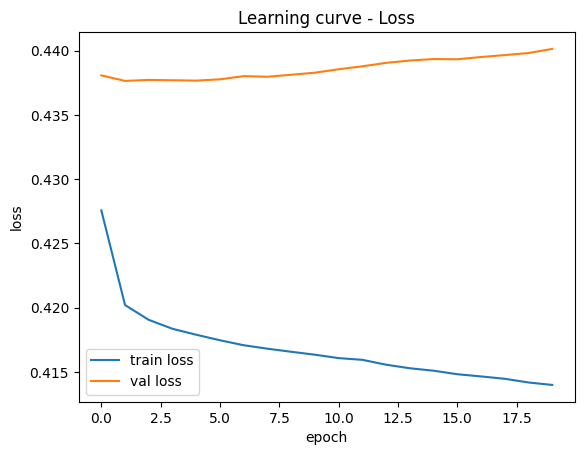

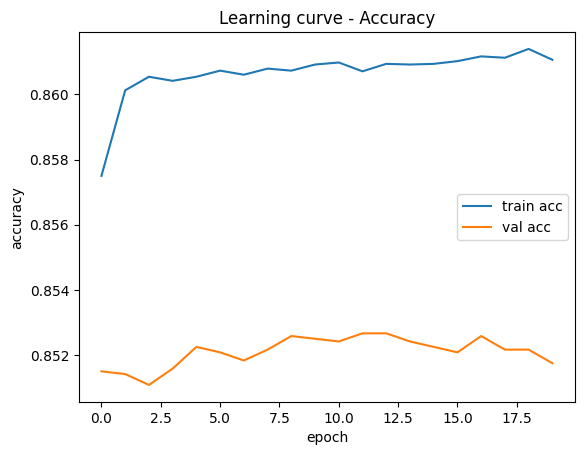

In [25]:
plot_learning_curves(history)

In [26]:
val_loss, val_acc = sup_model.evaluate(X_val, y_val, verbose=0)

print(f"Validation loss = {val_loss:.4f}")
print(f"Validation accuracy = {val_acc:.4f}")


Validation loss = 0.4401
Validation accuracy = 0.8518


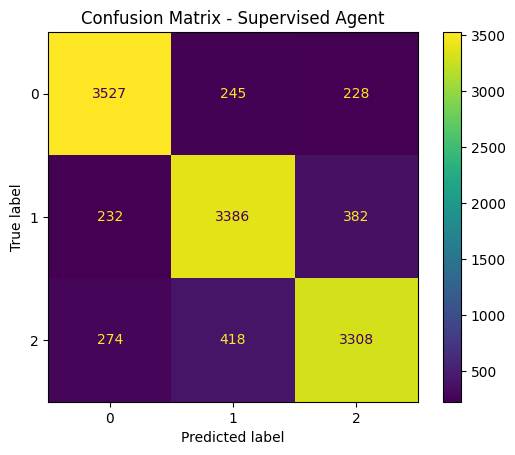

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_cls = np.argmax(logits, axis=1)
cm = confusion_matrix(y_val, y_pred_cls)

disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title("Confusion Matrix - Supervised Agent")
plt.show()


In [28]:
y_pred = sup_model.predict(X_val, batch_size=512)
y_pred_cls = np.argmax(y_pred, axis=1)

unique, counts = np.unique(y_pred_cls, return_counts=True)
print("Prediction distribution:", dict(zip(unique, counts)))


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Prediction distribution: {np.int64(0): np.int64(4033), np.int64(1): np.int64(4049), np.int64(2): np.int64(3918)}


In [29]:
sup_model.save("supervised_model.h5")